In [1]:
import torch

In [2]:
! pip install dgl-cu111 -f https://data.dgl.ai/wheels/repo.html 

Looking in links: https://data.dgl.ai/wheels/repo.html
     |████████████████████████████████| 165.0 MB 35 kB/s 


In [3]:
import dgl
import dgl.function as fn
from dgl import DGLGraph
from dgl.data import citation_graph as citegrh
from dgl.data import DGLDataset
# pytorch
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
# other
import time
import numpy as np
import random as rng
import scipy.sparse as ss
import networkx as nx
import pickle
from sklearn import metrics as skmetrics
from scipy import sparse as sp
from sklearn.metrics import accuracy_score as acc
from math import log


DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [4]:
from google.colab import files
def upload_files():
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())

upload_files()
#Upload LGNN.py, performance.py and SparseMax.py

Saving git_edges.csv to git_edges.csv


['git_edges.csv']

In [7]:
upload_files()

Saving papers.csv to papers.csv


['papers.csv']

In [ ]:
pip install LGNN

ERROR: Could not find a version that satisfies the requirement LGNN (from versions: none)
ERROR: No matching distribution found for LGNN


In [ ]:
import LGNN
#from LGNN import LGNN_Net
import importlib
importlib.reload(LGNN)

ModuleNotFoundError: ignored

In [8]:
# LGNN Definition


class LGNN_Net(nn.Module):
    """This is a whole LGNN"""

    def __init__(
        self, g, in_feats, hidden_size, hidden_layers, out_feats, dropout, batchnorm, lg, radius
    ):
        super(LGNN_Net, self).__init__()
        self.g = g
        self.lg = lg
        in_feats = [in_feats] + [hidden_size] * hidden_layers
        self.module_list = nn.ModuleList(
            [LGNNModule(m, n, radius, batchnorm) for m, n in zip(in_feats[:-1], in_feats[1:])]
        )
        self.linear = nn.Linear(in_feats[-1], out_feats)
        self.dropout = nn.Dropout(dropout)

        self.pmpd = self.g.edges()[0]

        # compute the degrees
        self.deg_g = self.g.in_degrees().float().unsqueeze(1)
        self.deg_lg = self.lg.in_degrees().float().unsqueeze(1)

    def forward(self, features):
        (h, lg_h) = features
        for i, module in enumerate(self.module_list):
            if i == len(self.module_list) - 1:
                h = module(
                    self.g, self.lg, h, lg_h, self.deg_g, self.deg_lg, self.pmpd, last=True
                )  # the last pass should only return h, otherwhise we get a memory leak
                h = self.dropout(h)
            else:
                h, lg_h = module(self.g, self.lg, h, lg_h, self.deg_g, self.deg_lg, self.pmpd)
                h = self.dropout(h)
                lg_h = self.dropout(lg_h)
        h = self.linear(h)
        h = F.log_softmax(h, 1)
        return h


In [9]:

class LGNNModule(nn.Module):
    """This is a graph network block of LGNN"""

    def __init__(self, in_feats, out_feats, radius, batchnorm):
        super().__init__()
        self.out_feats = out_feats
        self.radius = radius

        new_linear = lambda: nn.Linear(in_feats, out_feats)
        new_linear_list = lambda: nn.ModuleList([new_linear() for i in range(radius)])

        self.theta_x, self.theta_deg, self.theta_y = new_linear(), new_linear(), new_linear()
        self.theta_list = new_linear_list()

        self.gamma_y, self.gamma_deg, self.gamma_x = new_linear(), new_linear(), new_linear()
        self.gamma_list = new_linear_list()

        self.batchnorm = batchnorm
        self.bn_x = nn.BatchNorm1d(out_feats)
        self.bn_y = nn.BatchNorm1d(out_feats)

    def aggregate(self, a_graph, z):
        z_list = []
        a_graph.ndata['z'] = z
        # ntid = a_graph.get_ntype_id(None)
        #a_graph._set_n_repr(ntid, u= z, data = {"z": z})
        a_graph.update_all(fn.copy_src(src="z", out="m"), fn.sum(msg="m", out="z"))
        z_list.append(a_graph.ndata["z"])
        for i in range(self.radius - 1):
            for j in range(2 ** i):
                a_graph.update_all(fn.copy_src(src="z", out="m"), fn.sum(msg="m", out="z"))
            z_list.append(a_graph.ndata["z"])
        return z_list
        

    def forward(self, g, lg, x, y, deg_g, deg_lg, pm_pd, last=False):
        pmpd_x = F.embedding(pm_pd, x)

        sum_x = sum(theta(z) for theta, z in zip(self.theta_list, self.aggregate(g, x)))

        g.edata["y"] = y
        g.update_all(fn.copy_edge(edge="y", out="m"), fn.sum("m", "pmpd_y"))
        pmpd_y = g.ndata.pop("pmpd_y")

        x = self.theta_x(x) + self.theta_deg(deg_g * x) + sum_x + self.theta_y(pmpd_y)
        n = self.out_feats // 2
        x = th.cat([x[:, :n], F.relu(x[:, n:])], 1)
        if self.batchnorm:
            x = self.bn_x(x)

        if last:
            return x  # do not compute the rest of the lgnn part to avoid memory leak

        sum_y = sum(gamma(z) for gamma, z in zip(self.gamma_list, self.aggregate(lg, y)))

        y = self.gamma_y(y) + self.gamma_deg(deg_lg * y) + sum_y + self.gamma_x(pmpd_x)
        y = th.cat([y[:, :n], F.relu(y[:, n:])], 1)
        if self.batchnorm:
            y = self.bn_y(y)

        return x, y

## Loading the dataset

In [ ]:
#Loading CORA
data = citegrh.load_cora()

g = data[0]
num_class = data.num_classes

features = g.ndata['feat']

train_mask = g.ndata['train_mask']
val_mask = g.ndata['val_mask']
test_mask = g.ndata['test_mask']
labels = g.ndata['label']

# add self loop
#g.remove_edges_from(nx.selfloop_edges(g))
g  = dgl.remove_self_loop(g)
#g = DGLGraph(g)
#g.add_edges(g.nodes(), g.nodes())

comb_mask = th.zeros(len(train_mask), dtype=torch.bool)

for i in range(len(comb_mask)):
    if test_mask[i] or train_mask[i] or val_mask[i]:
        comb_mask[i] = True

lg_feat = np.vstack([features[e[0],:]*features[e[1],:] for e in data.graph.edges])

Extracting file to /root/.dgl/cora_v2
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


/usr/local/lib/python3.7/dist-packages/dgl/data/utils.py:286: UserWarning: Property dataset.graph will be deprecated, please use dataset[0] instead.
  warnings.warn('Property {} will be deprecated, please use {} instead.'.format(old, new))


In [ ]:
#load pubmed
from dgl.data import PubmedGraphDataset as pubmed
import networkx as nx

data = pubmed()

# features = th.FloatTensor(data.features)
# labels = th.LongTensor(data.labels)
# mask = th.ByteTensor(data.train_mask)
#g1 = data.graph

##
g = data[0]
num_class = data.num_classes

features = g.ndata['feat']

train_mask = g.ndata['train_mask']
val_mask = g.ndata['val_mask']
test_mask = g.ndata['test_mask']
labels = g.ndata['label']

# add self loop
#g.remove_edges_from(nx.selfloop_edges(g))
g  = dgl.remove_self_loop(g)
#g = DGLGraph(g)
#g.add_edges(g.nodes(), g.nodes())

comb_mask = torch.zeros(len(train_mask), dtype=torch.bool)

for i in range(len(comb_mask)):
    if test_mask[i] or train_mask[i] or val_mask[i]:
        comb_mask[i] = True
lg_feat = np.vstack([features[e[0],:]*features[e[1],:] for e in data.graph.edges])

  NumNodes: 19717
  NumEdges: 88651
  NumFeats: 500
  NumClasses: 3
  NumTrainingSamples: 60
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


/usr/local/lib/python3.7/dist-packages/dgl/data/utils.py:286: UserWarning: Property dataset.graph will be deprecated, please use dataset[0] instead.
  warnings.warn('Property {} will be deprecated, please use {} instead.'.format(old, new))


In [10]:
# load github
# Generating a dgl graph from the given csv files of github dataset at: http://snap.stanford.edu/data/github-social.html

class GitHubDataset(DGLDataset):
    def __init__(self):
        super().__init__(name='github_dataset')

    def process(self):
        nodes_data = pd.read_csv('papers.csv')
        edges_data = pd.read_csv('git_edges.csv')
        node_target = pd.read_csv('musae_git_target.csv')
        node_features = torch.from_numpy(nodes_data.to_numpy())
        node_labels = torch.from_numpy(node_target["ml_target"].astype('category').cat.codes.to_numpy())
        #edge_features = torch.from_numpy(edges_data['Weight'].to_numpy())
        edges_src = torch.from_numpy(edges_data['source'].to_numpy())
        edges_dst = torch.from_numpy(edges_data['target'].to_numpy())

        self.graph = dgl.graph((edges_src, edges_dst), num_nodes=nodes_data.shape[0])
        self.graph.ndata['feat'] = node_features
        self.graph.ndata['label'] = node_labels
        #self.graph.edata['weight'] = edge_features
        # If your dataset is a node classification dataset, you will need to assign
        # masks indicating whether a node belongs to training, validation, and test set.
        n_nodes = nodes_data.shape[0]
        n_train = int(n_nodes * 0.6)
        n_val = int(n_nodes * 0.2)
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        val_mask = torch.zeros(n_nodes, dtype=torch.bool)
        test_mask = torch.zeros(n_nodes, dtype=torch.bool)
        train_mask[:n_train] = True
        val_mask[n_train:n_train + n_val] = True
        test_mask[n_train + n_val:] = True
        self.graph.ndata['train_mask'] = train_mask
        self.graph.ndata['val_mask'] = val_mask
        self.graph.ndata['test_mask'] = test_mask

    def __getitem__(self, i):
        return self.graph

    def __len__(self):
        return 1

data = GitHubDataset()
graph = data[0]

num_class = 2

features = graph.ndata['feat']

train_mask = graph.ndata['train_mask']
val_mask = graph.ndata['val_mask']
test_mask = graph.ndata['test_mask']
labels = graph.ndata['label']

# add self loop
#g.remove_edges_from(nx.selfloop_edges(g))
graph = dgl.remove_self_loop(graph)
#g = DGLGraph(g)
graph.add_edges(graph.nodes(), graph.nodes())

comb_mask = torch.zeros(len(train_mask), dtype=torch.bool)

for i in range(len(comb_mask)):
    if test_mask[i] or train_mask[i] or val_mask[i]:
        comb_mask[i] = True

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  del sys.path[0]


In [ ]:
# Generating a dgl graph from the given csv files of github dataset at: http://snap.stanford.edu/data/github-social.html

# class GitHubDataset(DGLDataset):
#     def __init__(self):
#         super().__init__(name='github_dataset')

#     def process(self):
#         nodes_data = pd.read_csv('drive/MyDrive/CSCE689/data_git/papers.csv')
#         edges_data = pd.read_csv('drive/MyDrive/CSCE689/data_git/git_edges.csv')
#         node_target = pd.read_csv('drive/MyDrive/CSCE689/data_git/musae_git_target.csv')
#         node_features = torch.from_numpy(nodes_data.to_numpy())
#         node_labels = torch.from_numpy(node_target["ml_target"].astype('category').cat.codes.to_numpy())
#         #edge_features = torch.from_numpy(edges_data['Weight'].to_numpy())
#         edges_src = torch.from_numpy(edges_data['source'].to_numpy())
#         edges_dst = torch.from_numpy(edges_data['target'].to_numpy())

#         self.graph = dgl.graph((edges_src, edges_dst), num_nodes=nodes_data.shape[0])
#         self.graph.ndata['feat'] = node_features
#         self.graph.ndata['label'] = node_labels
#         #self.graph.edata['weight'] = edge_features

#         # If your dataset is a node classification dataset, you will need to assign
#         # masks indicating whether a node belongs to training, validation, and test set.
#         n_nodes = nodes_data.shape[0]
#         n_train = int(n_nodes * 0.6)
#         n_val = int(n_nodes * 0.2)
#         train_mask = torch.zeros(n_nodes, dtype=torch.bool)
#         val_mask = torch.zeros(n_nodes, dtype=torch.bool)
#         test_mask = torch.zeros(n_nodes, dtype=torch.bool)
#         train_mask[:n_train] = True
#         val_mask[n_train:n_train + n_val] = True
#         test_mask[n_train + n_val:] = True
#         self.graph.ndata['train_mask'] = train_mask
#         self.graph.ndata['val_mask'] = val_mask
#         self.graph.ndata['test_mask'] = test_mask

#     def __getitem__(self, i):
#         return self.graph

#     def __len__(self):
#         return 1

# dataset = GitHubDataset()
# graph = dataset[0]

In [ ]:
# num_class = 2

# features = graph.ndata['feat']

# train_mask = graph.ndata['train_mask']
# val_mask = graph.ndata['val_mask']
# test_mask = graph.ndata['test_mask']
# labels = graph.ndata['label']

# # add self loop
# #g.remove_edges_from(nx.selfloop_edges(g))
# graph = dgl.remove_self_loop(graph)
# #g = DGLGraph(g)
# graph.add_edges(graph.nodes(), graph.nodes())

# comb_mask = torch.zeros(len(train_mask), dtype=torch.bool)

# for i in range(len(comb_mask)):
#     if test_mask[i] or train_mask[i] or val_mask[i]:
#         comb_mask[i] = True


In [12]:
# create line graph for all dataset
#graph = g
lg = graph.line_graph(backtracking=False)

In [11]:
print('The graph has %d nodes.' % graph.number_of_nodes())
print('The graph has %d edges.' % graph.number_of_edges())

The graph has 37700 nodes.
The graph has 326703 edges.


In [ ]:
#partition for cora
# Training set selection

percentage_train = 0.1
percentage_val = 0.1

#with open("drive/MyDrive/CSCE689/data/cora_permutation1.pickle","rb") as f:
#    perm1 = pickle.load(f)
#from itertools import permutations

num_node = [i for i in range(1,g.number_of_nodes()+1)]
perm1 = num_node #list(permutations(num_node))
mask_train = np.zeros(g.number_of_nodes())
mask_val = np.zeros(g.number_of_nodes())

i_train = int(percentage_train*g.number_of_nodes())
i_val = i_train + int(percentage_val*g.number_of_nodes())
mask_train[perm1[0:i_train)]] = 1
mask_val[perm1[range(i_train,i_val)]] = 1
mask_train = th.BoolTensor(mask_train)
mask_val = th.BoolTensor(mask_val)

SyntaxError: ignored

In [ ]:
#partition for pubmed mask

percentage_train = 0.1
percentage_val = 0.1
with open("pubmed_permutation6.pickle","rb") as f:
    perm1 = pickle.load(f)
mask_train = np.zeros(g.number_of_nodes())
mask_val = np.zeros(g.number_of_nodes())

i_train = int(percentage_train*g.number_of_nodes())
i_val = i_train + int(percentage_val*g.number_of_nodes())
mask_train[perm1[range(0,i_train)]] = 1
mask_val[perm1[range(i_train,i_val)]] = 1
mask_train = th.BoolTensor(mask_train)
mask_val = th.BoolTensor(mask_val)

In [13]:
#partition for github
percentage_train = 0.6
percentage_val = 0.2

with open("git_permutation4.pickle","rb") as f:
    perm1 = pickle.load(f)
mask_train = np.zeros(graph.number_of_nodes())
mask_val = np.zeros(graph.number_of_nodes())

i_train = int(percentage_train*graph.number_of_nodes())
i_val = i_train + int(percentage_val*graph.number_of_nodes())
mask_train[perm1[range(0,i_train)]] = 1
mask_val[perm1[range(i_train,i_val)]] = 1
mask_train = th.BoolTensor(mask_train)
mask_val = th.BoolTensor(mask_val)

FileNotFoundError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Training Block

# create the model
degrees = False
if degrees:
    # use degree as the input feature
    # compute the degrees
    g_feat = g.in_degrees().float().unsqueeze(1)
    lg_feat = lg.in_degrees().float().unsqueeze(1)  
else:
    # use astracts as input feature
    g_feat = features
    lg_feat = th.FloatTensor(np.vstack([features[e[0],:] for e in data.graph.edges]))
    
net = LGNN_Net(g=g,in_feats=g_feat.shape[1],hidden_size=21,hidden_layers=2,out_feats=7,
               dropout=0.1,batchnorm=False,lg=lg,radius=2)

# define the optimizer
optimizer = th.optim.Adam(net.parameters(), lr=0.01, weight_decay=0.1)

all_logits = []
all_losses = []
all_losses_val = []

# train
for epoch in range(1000):

    # Compute loss for test nodes (only for validation, not used by optimizer)
    net.eval()
    prediction = F.log_softmax(net((g_feat, lg_feat)),1)
    val_loss = F.nll_loss(prediction.detach()[mask_val], labels[mask_val])
    all_losses_val.append(val_loss.item())
    val_acc = acc(labels[mask_val],prediction.detach()[mask_val].numpy().argmax(axis=1))
    net.train()

    logits = net((g_feat, lg_feat))
    
    # Save logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)

    # Compute loss for train nodes
    loss = F.nll_loss(logp[mask_train], labels[mask_train])
    all_losses.append(loss.detach().item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print('Epoch %d | Loss: %.4f | Total: %.4f | Acc: %.4f' % (epoch, loss.item(), val_loss.item(),val_acc))

In [17]:
import time
g= graph
# create the model
degrees = True
if degrees:
    # use degree as the input feature
    # compute the degrees
    g_feat = g.in_degrees().float().unsqueeze(1)
    lg_feat = lg.in_degrees().float().unsqueeze(1)  
else:
    # use astracts as input feature
    g_feat = th.FloatTensor(data.features)
    lg_feat = th.FloatTensor(np.vstack([data.features[e[0],:] for e in data.graph.edges]))
features = (g_feat,lg_feat)
    
net = LGNN_Net(g=g,in_feats=g_feat.shape[1],hidden_size=21,hidden_layers=2,out_feats=7,
               dropout=0.1,batchnorm=False,lg=lg,radius=2)
#print(net)

optimizer = th.optim.Adam(net.parameters(), lr=1e-2, weight_decay=1e-2)
net.train() # Set to training mode (use dropout)

dur = []
loss_ev = []
current_best = 0 #arbitrarily high
current_best_epoch = 0
current_best_params = None
no_improvement_for = 0

for epoch in range(10000):
    if epoch >=3:
        t0 = time.time()

    # Compute loss for test nodes (only for validation, not used by optimizer)
    net.eval()
    prediction = net(features)
    train_rand=pf.rand_score(labels[mask_train].numpy(),np.argmax(prediction[mask_train].detach().numpy(), axis=1))
    validation_rand=pf.rand_score(labels[mask_val].numpy(),np.argmax(prediction[mask_val].detach().numpy(), axis=1))
    if train_rand>current_best:
        current_best = train_rand
        current_best_epoch = epoch
        current_best_params = copy.deepcopy(net.state_dict())
        no_improvement_for = 0
    else: no_improvement_for += 1
    
    if no_improvement_for>100:
        break
    
    net.train()

    # Compute loss for train nodes
    logits = net(features)

    loss = loss_function.approximate_loss(logits,mask_train,nclasses=7)
    loss_ev.append(loss.detach().item())

    #loss = F.nll_loss(logits[mask_train], labels[mask_train])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch >=3:
        dur.append(time.time() - t0)
        print(f"Epoch {epoch:05d} | Loss {loss.item():.4f} | Train.Rand {train_rand:.4f} | Valid.Rand {validation_rand:.4f} | Time(s) {np.mean(dur):.4f}")
    else:
        print(f"Epoch {epoch:05d} | Loss {loss.item():.4f} | Train.Rand {train_rand:.4f} | Valid.Rand {validation_rand:.4f} | Time(s) unknown")
        
net.load_state_dict(current_best_params)

NameError: ignored

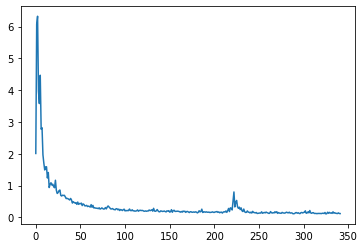

In [ ]:
import seaborn as sns
sns.lineplot(x=range(len(loss_ev)), y=loss_ev)

In [ ]:
import performance as pf
import copy
loss_function = pf.perm_inv_loss(labels)


In [ ]:
net.load_state_dict(current_best_params)


<All keys matched successfully>

In [ ]:
# Visualise predictions
net.eval() # Set net to evaluation mode (deactivates dropout)
final_prediction = net(features).detach()
a = np.transpose(np.vstack([final_prediction[comb_mask].numpy().argmax(axis=1),labels[comb_mask].numpy()]))
a[a[:,0].argsort()][np.random.choice(range(a.shape[0]),size=10)]


array([[0, 5],
       [3, 3],
       [5, 2],
       [1, 0],
       [4, 6],
       [4, 0],
       [2, 1],
       [6, 6],
       [3, 3],
       [5, 2]])

In [ ]:
# Performnace evaluation functions

def variation_of_information_score(labels, preds):
    def mi(x, y):
        contingency = skmetrics.cluster.contingency_matrix(x, y, sparse=True)
        # print(contingency.todense())
        nzx, nzy, nz_val = sp.find(contingency)
        contingency_sum = contingency.sum()

        pi = np.ravel(contingency.sum(axis=1))
        pj = np.ravel(contingency.sum(axis=0))
        # print(nz_val)
        log_contingency_nm = np.log(nz_val)
        # print(log_contingency_nm)
        contingency_nm = nz_val / contingency_sum
        # print(contingency_nm)

        # Don't need to calculate the full outer product, just for non-zeroes
        outer = pi.take(nzx).astype(np.int64, copy=False) * pj.take(nzy).astype(
            np.int64, copy=False
        )
        # print(outer)
        log_outer = -np.log(outer) + log(pi.sum()) + log(pj.sum())
        # print(log_outer)
        mi = (
            contingency_nm * (log_contingency_nm - log(contingency_sum))
            + contingency_nm * log_outer
        )
        # print(mi)
        return mi.sum()

    return mi(labels, labels) + mi(preds, preds) - 2 * mi(labels, preds)


def mutual_info_score(labels, preds):
    return skmetrics.adjusted_mutual_info_score(labels, preds, average_method="arithmetic")

def compute_performance(labels, logits, splits):
    logits = logits.detach().numpy()
    preds = np.argmax(logits, axis=1)
    labels = labels.numpy()
    pred_sets = {
        "All ": preds,
        "Train": preds[mask_train],
        "Val": preds[mask_val],
        "Test": preds[test_mask],
    }
    label_sets = {
        "All ": labels,
        "Train": labels[mask_train],
        "Val": labels[mask_val],
        "Test": labels[test_mask],
    }
    eval_functions = {
        "Rand-Index": rand_score,
        "Mutual Information": mutual_info_score,
        "Variation of Information": variation_of_information_score,
    }
    scores = {
        subset: {
            name: func(label_sets[subset], pred_sets[subset])
            for name, func in eval_functions.items()
        }
        for subset in pred_sets.keys()
    }
    return scores

def performance_as_df(labels, logits, splits):
    scores = compute_performance(labels, logits, splits)
    return pd.DataFrame(scores)

def rand_score(labels, preds):
    return skmetrics.adjusted_rand_score(labels, preds)

In [ ]:
net.eval() # Set net to evaluation mode (deactivates dropout)
final_prediction = net(features).detach()
performance_as_df(labels,final_prediction,comb_mask)

,All,Train,Val,Test
Rand-Index,0.558294,0.971305,0.492320,0.554135
Mutual Information,0.532625,0.969968,0.495712,0.532490
Variation of Information,1.691030,0.105132,1.753864,1.678290
